In [15]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import kagglehub

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
transform_validacao_teste = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [18]:
path = kagglehub.dataset_download("misrakahmed/vegetable-image-dataset")

In [19]:
validacao_pasta = os.path.join(path, "Vegetable Images", "validation")
teste_pasta = os.path.join(path, "Vegetable Images", "test")

In [20]:
dados_validacao = ImageFolder(root = validacao_pasta, transform = transform_validacao_teste)
dados_teste = ImageFolder(root = teste_pasta, transform = transform_validacao_teste)

In [21]:
classes_do_dataset = dados_teste.classes

In [22]:
tamanho_das_imagens = 224   #tamanho das imagens do Dataset
tamanho_do_kernel = 3 #tamanho do Kernel escolhido pois 5x5 ou 7x7 aumentam muito o numero de parametros 
stride = 1  #tanto Stride = 1 e Padding = 1 foram escolhidos para garantir que nao tenha perca de detalhes da imagem
padding = 1  
tamanho_do_max_pooling = 2  #max pooling 2x2
learning_rate = 0.0005

In [23]:
def CNN():
    class classifica_vegetais(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 64, tamanho_do_kernel, stride, padding)     #PRIMERIA camada de convoluÃ§Ã£o, recebendo 3 entradas (RGB) e resulta em 64 feature_maps
 
            self.conv2 = nn.Conv2d(64, 128, tamanho_do_kernel, stride, padding)   #SEGUNDA camada de convoluÃ§Ã£o, recebendo 3 entradas (RGB) e resulta em 128 feature_maps
            self.conv3 = nn.Conv2d(128, 256, tamanho_do_kernel, stride, padding)  #TRECEIRA camada de convoluÃ§Ã£o, recebendo 3 entradas (RGB) e resulta em 256 feature_maps
            self.conv4 = nn.Conv2d(256, 512, tamanho_do_kernel, stride, padding)  #QUARTA camada de convoluÃ§Ã£o, recebendo 3 entradas (RGB) e resulta em 512 feature_maps
            self.conv5 = nn.Conv2d(512, 512, tamanho_do_kernel, stride, padding) #QUINTA camada de convoluÃ§Ã£o, recebendo 3 entradas (RGB) e resulta em 1024 feature_maps

            #self.conv6 = nn.Conv2d(1024, 1024, tamanho_do_kernel, stride, padding)#SEXTA camada de convoluÃ§Ã£o, recebendo 3 entradas (RGB) e resulta em 1024 feature_maps
                                                                            #entre 1024 e sai 1024 porem a convoluÃ§Ã£o ainda Ã© feita, gerando novos feature_maps
                                                                            #servindo para aumentar ainda mais a profundidade da rede    
            
            self.fc1 = nn.Linear(512 * 7 * 7, 512)    #PRIMEIRA camada FULLY CONNECTED, recebendo 1024 * 3 * 3 = 9216 e reduzindo para 1024
                                                        #ele Ã© * 3 * 3 pois sÃ£o 6 camadas e vamos dividindo a partir de 224 (tamanho da imagem)
                                                        #224/2=112 ; 112/2=56 ; 56/2=28 ; 28/2=14 ; 14/2=7 ; 7/2=3.5 (arredondei pra baixo, portanto 3)
            self.output = nn.Linear(512, 15)   #camada FINAL recebendo 1024 e resultando em apenas 15 (numero de classes)  
        def forward(self, x):
            x = F.relu(self.conv1(x))   #PRIMEIRA convoluÃ§Ã£o e RELU
            x = F.max_pool2d(x, tamanho_do_max_pooling) #PRIMEIRO max pooling
            x = F.relu(self.conv2(x))   #SEGUNDA convoluÃ§Ã£o e RELU
            x = F.max_pool2d(x, tamanho_do_max_pooling) #SEGUNDA max pooling
            x = F.relu(self.conv3(x))   #TERCEIRA convoluÃ§Ã£o e RELU
            x = F.max_pool2d(x, tamanho_do_max_pooling) #TERCEIRA max pooling
      
            x = F.relu(self.conv4(x))   #QUARTA convoluÃ§Ã£o e RELU
            x = F.max_pool2d(x, tamanho_do_max_pooling) #QUARTA max pooling
            
            x = F.relu(self.conv5(x))   #QUINTA convoluÃ§Ã£o e RELU
            x = F.max_pool2d(x, tamanho_do_max_pooling) #QUINTA max pooling

            #x = F.relu(self.conv6(x))   #SEXTA convoluÃ§Ã£o e RELU
            #x = F.max_pool2d(x, tamanho_do_max_pooling) #SEXTA max pooling
            
            x = torch.flatten(x, 1) #transforma o vetor MULTIDIMENSIONAL em um vetor UNIDIMENSIONAL para utilizar nas FCs (FULLY CONNECTED)
            
            x = F.relu(self.fc1(x)) #PRIMEIRA camada FULLY CONNECTED e RELU
            x = self.output(x)  #retorna 15 LOGITS
            
            return x
    modelo = classifica_vegetais()  #INICIA o modelo
    funcao_loss = nn.CrossEntropyLoss() #define FUNCAO DE LOSS (softmax estÃ¡ dentro da CrossEntropyLoss() ) 
    otimizador = torch.optim.Adam(modelo.parameters(), lr=learning_rate)    #define o otimzador que sera utilizado o Learning Rate de cada parametro
    return modelo, funcao_loss, otimizador

In [24]:
def testar_e_mostrar(caminho_imagem, modelo, transform, classes, device="cuda"):
    imagem = Image.open(caminho_imagem).convert("RGB")
    imagem_tensor = transform(imagem).unsqueeze(0).to(device)
    modelo.eval()
    with torch.no_grad():
        logits = modelo(imagem_tensor)
        previsao = torch.argmax(logits, axis = 1).item()
    plt.imshow(imagem)
    plt.title(f"Classe prevista: {classes[previsao]}")
    plt.axis("off")
    plt.show()  
    return previsao

In [25]:
modelo, _, _ = CNN()
modelo = modelo.to(device)

In [26]:
modelo.load_state_dict(torch.load("modelos/modelo_treinado.pth", map_location = device) )

<All keys matched successfully>

In [27]:
imagem_para_testar = "brocolis3.jpg"   

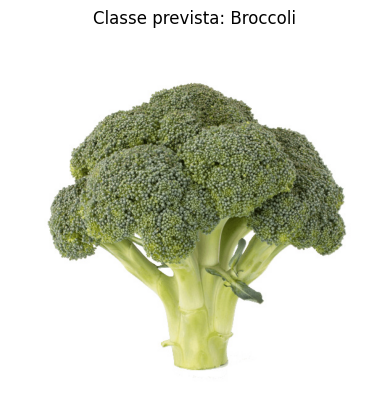

4

In [28]:
testar_e_mostrar(caminho_imagem = imagem_para_testar, modelo = modelo, transform = transform_validacao_teste, classes = classes_do_dataset, device = device)